## Setup

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")
torch.cuda.set_per_process_memory_fraction(0.8)

Usando dispositivo: cuda


In [3]:
model_name = "bert-base-multilingual-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

In [18]:
def plot_token_count(row1, row2, log=False, bins=50):
    # compute token counts (including [CLS] and [SEP])
    token_counts_es = row1.apply(
        lambda txt: len(tokenizer.encode(txt))
    )

    token_counts_lf = row2.apply(
        lambda txt: len(tokenizer.encode(txt))
    )

    plt.figure(figsize=(10, 5))
    plt.hist(token_counts_es, bins=bins, alpha=0.5, label='Espaniol', color='r')
    plt.hist(token_counts_lf, bins=bins, alpha=0.5, label='Lunfardo', color='b', log=log)
    plt.axvline(512, color='r', linestyle='--', label='BERT max length')
    plt.xlabel("tokens")
    plt.ylabel("Cantidad de secuencias")
    plt.legend()
    plt.show()

    return token_counts_es, token_counts_lf

## 1000 dataset

In [ ]:
# cargamos los datos small
data = pd.read_csv('../../data/es_MX-es_LF_1000.txt', sep='\t', header=None)
data.columns = ['spanish', 'lunfardo']
data.head()

,spanish,lunfardo
0,representaciones de la tierra y el agua de sis...,¡las labras de la tierra y el agua mierda son ...
1,gente nadando en la alberca 2022 es una de las...,gente chapoteando en la pileta 2022 es uno de ...
2,tierra del sol se complace en presentar vicent...,tierra del sol se pone el moño pa' presentarte...
3,"trabajando con maestría diversas temáticas, si...","con un chamuyo bárbaro, el siso se mandó una b..."
4,la galería tierra del sol se encuentra en el 7...,la canchita tierra del sol la garrás en el 741...


In [5]:
# testeamos el tokenizador de BERT
input_0 = data['spanish'][0]
target_0 = data['lunfardo'][0]

print(f"Input: {input_0}")
print(f"Target: {target_0}")

print(tokenizer.tokenize(input_0))
print(tokenizer.tokenize(target_0))

print(tokenizer.encode(input_0))
print(tokenizer.encode(target_0))

Input: representaciones de la tierra y el agua de siso son el centro de una nueva exposición
Target: ¡las labras de la tierra y el agua mierda son el eje de un quilombo nuevo!
['representacion', '##es', 'de', 'la', 'tierra', 'y', 'el', 'agua', 'de', 'sis', '##o', 'son', 'el', 'centro', 'de', 'una', 'nueva', 'exposicion']
['¡', 'las', 'lab', '##ras', 'de', 'la', 'tierra', 'y', 'el', 'agua', 'mie', '##rda', 'son', 'el', 'eje', 'de', 'un', 'qui', '##lom', '##bo', 'nuevo', '!']
[101, 37889, 10165, 10102, 10106, 15456, 167, 10117, 13479, 10102, 21445, 10132, 10289, 10117, 11995, 10102, 10155, 12782, 38663, 102]
[101, 173, 10265, 31494, 13026, 10102, 10106, 15456, 167, 10117, 13479, 95096, 22741, 10289, 10117, 61529, 10102, 10119, 10379, 21440, 11976, 13976, 106, 102]


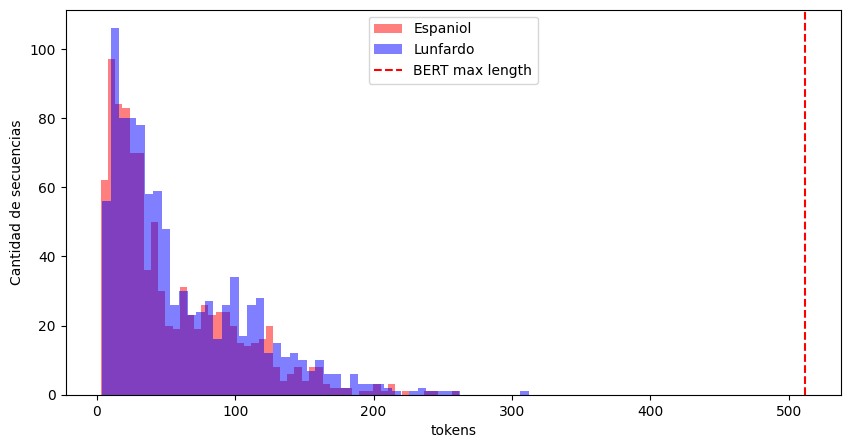

In [6]:
import matplotlib.pyplot as plt

plot_token_count(data['spanish'], data['lunfardo'])

Truncamos a 256 tokens para poder procesar las 2 secuencias al mismo tiempo

In [7]:
BERT = BertModel.from_pretrained("bert-base-multilingual-uncased").eval()
batch0 = torch.tensor(tokenizer.encode(input_0)).unsqueeze(0)

with torch.inference_mode():
    bert_output = BERT(batch0)

print(input_0)
print(tokenizer.encode(input_0))
print(len(tokenizer.encode(input_0)))
print(batch0.shape)
print(bert_output.last_hidden_state.shape) # ultima capa oculta
print(bert_output.pooler_output.shape) # salida de la capa de pooling

representaciones de la tierra y el agua de siso son el centro de una nueva exposición
[101, 37889, 10165, 10102, 10106, 15456, 167, 10117, 13479, 10102, 21445, 10132, 10289, 10117, 11995, 10102, 10155, 12782, 38663, 102]
20
torch.Size([1, 20])
torch.Size([1, 20, 768])
torch.Size([1, 768])


In [8]:
tokenizer.decode(tokenizer.encode(input_0))

'[CLS] representaciones de la tierra y el agua de siso son el centro de una nueva exposicion [SEP]'

In [9]:
bert_output.pooler_output.shape

torch.Size([1, 768])

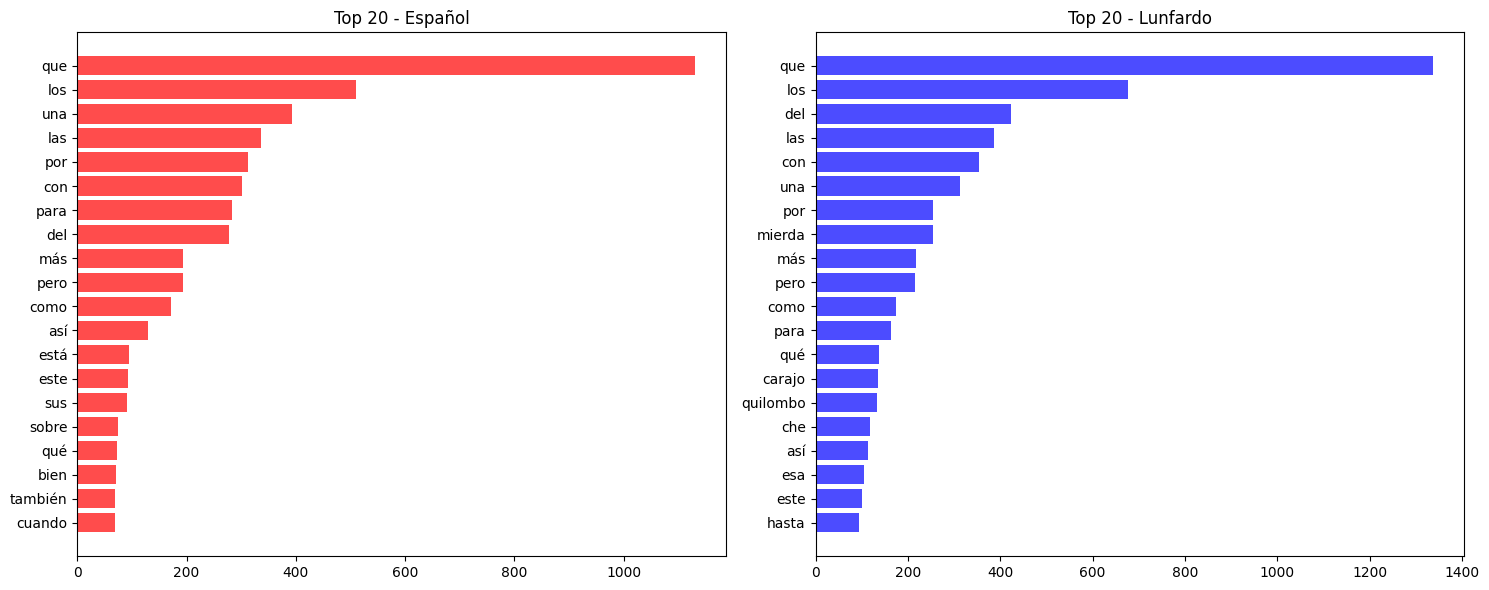

In [10]:
import matplotlib.pyplot as plt
from collections import Counter
import re

def get_top_words(texts, n=20):
    all_text = " ".join(texts)
    words = re.findall(r'\b[a-záéíóúñ]+\b', all_text.lower())
    words = [w for w in words if len(w) > 2]
    return Counter(words).most_common(n)

spanish_top = get_top_words(data['spanish'])
lunfardo_top = get_top_words(data['lunfardo'])

# grafico comparativo
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

words_es = [w for w, c in spanish_top]
counts_es = [c for w, c in spanish_top]
ax1.barh(words_es, counts_es, color='red', alpha=0.7)
ax1.set_title('Top 20 - Español')
ax1.invert_yaxis()

words_lf = [w for w, c in lunfardo_top]
counts_lf = [c for w, c in lunfardo_top]
ax2.barh(words_lf, counts_lf, color='blue', alpha=0.7)
ax2.set_title('Top 20 - Lunfardo')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

In [11]:
tokenizer.sep_token_id

102

In [12]:
BERT = BertModel.from_pretrained("bert-base-multilingual-uncased").to(device).eval()
for param in BERT.parameters():
    param.requires_grad = False
embeddings = BERT.embeddings.word_embeddings.weight
del BERT
torch.cuda.empty_cache()
embeddings = embeddings.detach()

In [13]:
embeddings.shape

torch.Size([105879, 768])

In [14]:
torch.cuda.empty_cache()

In [15]:
embeddings = BertModel.from_pretrained("bert-base-multilingual-uncased").to(device).eval().embeddings.word_embeddings.weight.detach()
torch.cuda.empty_cache()
embeddings

tensor([[ 0.0572,  0.0410,  0.0418,  ..., -0.0093,  0.0087, -0.0015],
        [ 0.0530,  0.0282,  0.0274,  ..., -0.0146,  0.0084,  0.0024],
        [ 0.0617,  0.0041,  0.0368,  ...,  0.0005, -0.0120, -0.0046],
        ...,
        [ 0.0324,  0.0460,  0.0023,  ..., -0.0438, -0.0149,  0.0450],
        [ 0.0455,  0.0294,  0.0241,  ..., -0.0237, -0.0207,  0.0211],
        [ 0.0272,  0.0486,  0.0077,  ...,  0.0108, -0.0339,  0.0175]],
       device='cuda:0')

## 2M dataset

In [16]:
# cargamos los datos small
data = pd.read_csv('../../data/es-gl.txt', sep='\t', header=None, on_bad_lines='skip')
data.columns = ['spanish', 'gl']

# Count NaN values in each column
nan_counts = data.isna().sum()

# Get text length stats for each column
length_stats = {}
for col in ['spanish', 'gl']:
    lengths = data[col].dropna().apply(len)
    length_stats[col] = {
        'min_len': round(lengths.min()),
        'max_len': round(lengths.max()),
        'avg_len': round(lengths.mean()),
        'median_len': round(lengths.median())
    }

print("Lenght:", len(data))
print("NaN counts:\n", nan_counts)
print("\nLength stats (characters):")
for col, stats in length_stats.items():
    print(f"{col}: {stats}")

data.head()

Lenght: 1863187
NaN counts:
 spanish       0
gl         1627
dtype: int64

Length stats (characters):
spanish: {'min_len': 8, 'max_len': 39462, 'avg_len': 146, 'median_len': 124}
gl: {'min_len': 7, 'max_len': 42524, 'avg_len': 140, 'median_len': 118}


,spanish,gl
0,Esta vez el cuadro local con el segundo de la ...,Gañou confianza o cadro local co segundo da ta...
1,Notas especiales: Esta unidad puede moverse si...,Notas especiais: esta unidade pode moverse na ...
2,"En este último caso, normalmente es un rey, pe...","Neste último caso, normalmente é un rei, pero ..."
3,Además de nuestras oficinas provinciales y del...,Ademais das nosas oficinas provinciais e deleg...
4,Si tienes cualquier duda o sugerencia que hace...,Se tes calquera dúbida ou suxestión que nos fa...


In [17]:
data = data[-data['gl'].isna()]

Token indices sequence length is longer than the specified maximum sequence length for this model (2883 > 512). Running this sequence through the model will result in indexing errors


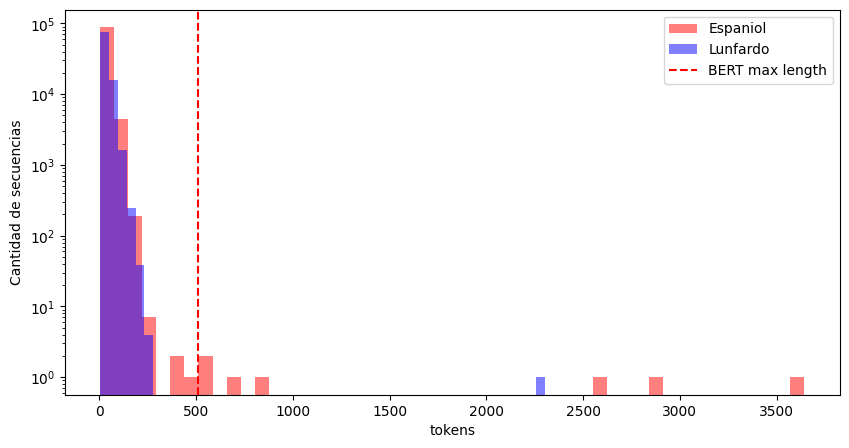

In [18]:
from sklearn.model_selection import train_test_split

_, data_sample = train_test_split(data, test_size=0.05, random_state=28)

plot_token_count(data_sample['spanish'], data_sample['gl'], log=True)

No es Lunfardo, es gl ~ gallego?

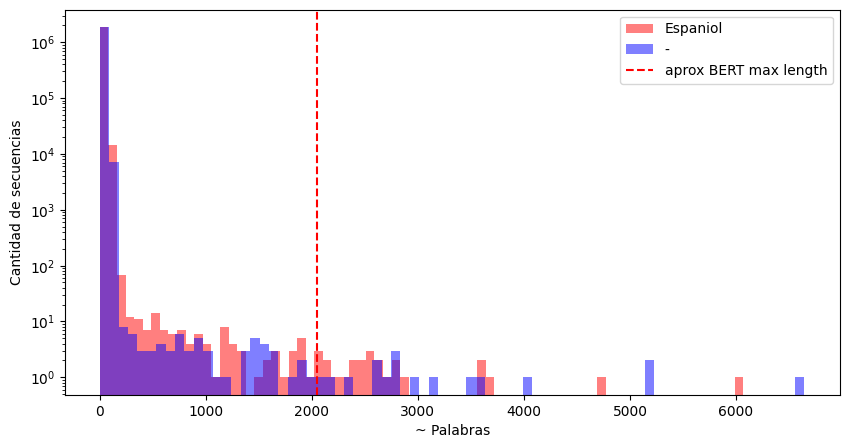

In [43]:
def plot_word_count(row1, row2, log=False):
    # compute token counts (including [CLS] and [SEP])
    token_counts_es = row1.apply(
        lambda txt: len(txt.split(' '))
    )

    token_counts_lf = row2.apply(
        lambda txt: len(txt.split(' '))
    )

    plt.figure(figsize=(10, 5))
    plt.hist(token_counts_es, bins=75, alpha=0.5, label='Espaniol', color='r')
    plt.hist(token_counts_lf, bins=75, alpha=0.5, label='-', color='b', log=log)
    plt.axvline(512*4, color='r', linestyle='--', label='aprox BERT max length')
    plt.xlabel("~ Palabras")
    plt.ylabel("Cantidad de secuencias")
    plt.legend()
    plt.show()

plot_word_count(data['spanish'], data['gl'], log=True)

In [46]:
# cota para filtrar
sum(data['spanish'].apply(lambda txt: len(txt.split(' '))) >= 512/8)

45474

In [56]:
data_filtered = data[data['spanish'].apply(lambda txt: len(txt.split(' '))) <= 512/8]
data_filtered

,spanish,gl
0,Esta vez el cuadro local con el segundo de la ...,Gañou confianza o cadro local co segundo da ta...
1,Notas especiales: Esta unidad puede moverse si...,Notas especiais: esta unidade pode moverse na ...
2,"En este último caso, normalmente es un rey, pe...","Neste último caso, normalmente é un rei, pero ..."
3,Además de nuestras oficinas provinciales y del...,Ademais das nosas oficinas provinciais e deleg...
4,Si tienes cualquier duda o sugerencia que hace...,Se tes calquera dúbida ou suxestión que nos fa...
...,...,...
1863182,"Se denominan anfidios, fasmidios o deiridios s...","Denomínanse anfidios, fasmidios ou deiridios s..."
1863183,"Lo importante, en el fondo, no es pertenecer a...","O importante, no fondo, non é pertencer a un g..."
1863184,El personaje de Lola vuelve a aparecer en la e...,A personaxe de Lola volveu aparecer na experim...
1863185,"También aparece el Golem, no obstante, no tien...","Tamén aparece o Golem, porén, non ten que ver ..."


In [60]:
len_words = data['spanish'].apply(lambda txt: len(txt.split(' ')))
data_filtered = data[(len_words >= 2) & (len_words <= 512/8)]
data_filtered

,spanish,gl
0,Esta vez el cuadro local con el segundo de la ...,Gañou confianza o cadro local co segundo da ta...
1,Notas especiales: Esta unidad puede moverse si...,Notas especiais: esta unidade pode moverse na ...
2,"En este último caso, normalmente es un rey, pe...","Neste último caso, normalmente é un rei, pero ..."
3,Además de nuestras oficinas provinciales y del...,Ademais das nosas oficinas provinciais e deleg...
4,Si tienes cualquier duda o sugerencia que hace...,Se tes calquera dúbida ou suxestión que nos fa...
...,...,...
1863182,"Se denominan anfidios, fasmidios o deiridios s...","Denomínanse anfidios, fasmidios ou deiridios s..."
1863183,"Lo importante, en el fondo, no es pertenecer a...","O importante, no fondo, non é pertencer a un g..."
1863184,El personaje de Lola vuelve a aparecer en la e...,A personaxe de Lola volveu aparecer na experim...
1863185,"También aparece el Golem, no obstante, no tien...","Tamén aparece o Golem, porén, non ten que ver ..."


In [50]:
from sklearn.model_selection import train_test_split

_, data_sampled = train_test_split(data_filtered, test_size=100000, random_state=28)
data_sampled

,spanish,gl
1271222,Si bien la biografía de Harrison cuenta alguna...,Aínda que a biografía de Harrison conta algunh...
1827622,"Quiero ser un buen compañero, preocuparme por ...","Quero ser un bo compañeiro, preocuparme polos ..."
1707207,A todos mis amigos que tengo fuera del Club.,A todos os meus amigos que teño fóra do Club.
89640,Material escolar y de escritorio para estudian...,Material escolar e de escritorio para estudant...
177574,"García ha destacado ""la variedad de perspectiv...","García destacou ""a variedade de perspectivas e..."
...,...,...
388779,Supone un coste económico y medioambiental que...,Supón un custo económico e ambiental que hai q...
434880,"Al medir las longitudes de onda, y compararlas...","Ao medir as lonxitudes de onda, e comparalas c..."
521261,Era frecuente el consumo de carne de aves y ce...,Era frecuente o consumo de carne de aves e por...
1519108,>> VITAMINAS Y MINERALES EN ALIMENTOS Qué lech...,>> ALIMENTOS RICOS EN FóSFORO Cal fermentado e...


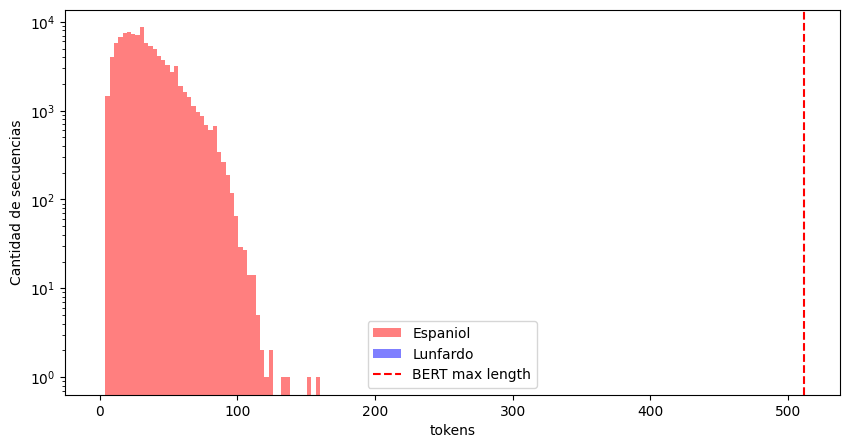

In [53]:
plot_token_count(data_sampled['spanish'], pd.Series([]), log=True)

In [55]:
data_sampled['spanish'].to_list()

['Si bien la biografía de Harrison cuenta algunas anécdotas de su etapa con los Beatles, se centra en su mayoría en los hobbies del artista, desde la jardinería hasta la Fórmula Uno.',
 'Quiero ser un buen compañero, preocuparme por los demás,',
 'A todos mis amigos que tengo fuera del Club.',
 'Material escolar y de escritorio para estudiantes, profesionales y empresas en Felanitx',
 'García ha destacado "la variedad de perspectivas y de ámbitos de acción" de las experiencias de trabajo, "una muestra significativa de la enorme dosis de iniciativa y de creatividad que atesora el profesorado que promueve el gallego dentro y fuera de las aulas".',
 'Todo nuestro amado Profeta (salla Allahu Alihi wa salam) dijo e hizo fue un acto de adoración, y los siguientes son solo algunos de los numerosos ejemplos.',
 'Broche en plata de primera ley (925 milésimas).',
 'Armas cortas, munición en el cargador, personal poseedor de licencia tipo B.',
 'Capital de largo plazo: es el tipo de capital del c

## 100k dataset

In [5]:
# cargamos los datos small
data = pd.read_csv('../../data/es-es_LF_100k.txt', sep='\t', header=None, on_bad_lines='skip')
data.columns = ['spanish', 'lunfardo']
data.head()

,spanish,lunfardo
0,las compañías que los venden afirman que son u...,los vivos que los largan aseguran que son un m...
1,academias y escuelas en quart de poblet página...,los colegios y las escuelas en quart de poblet...
2,existen varias áreas recreativas como la del m...,"hay varios chongos para reventar la tarde, com..."
3,moldeo por inyección de plástico,meterle el plástico a presión
4,"el equipo descendió a segunda división, quedan...","el cuadro se fue al tacho a la b, quedando emp..."


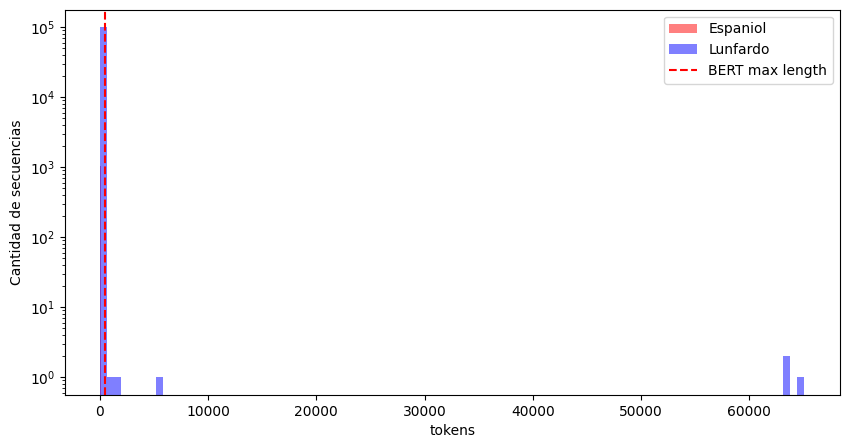

In [19]:
token_counts_es, token_counts_lf = plot_token_count(data['spanish'], data['lunfardo'], log=True, bins=100)

In [25]:
data[token_counts_lf >= 512]

,spanish,lunfardo
82568,blog camino sin límites 800 kilómetros para lu...,blog el posteo de la yeca la nota del chabón e...
94729,aeronáutica biotecnoloxía centros tecnológicos...,aeronautica aerotécnica de cotufas biotecnolox...
98671,"el uso ilícito, negligente, fraudulento, contr...","el chanchullo, el macaneo, la truchada, el qui..."
99061,"partiendo de esto, desde hace más de 10 años t...","mirá, de una, hace como diez y pico de años qu..."
99339,"el uso ilícito, negligente, fraudulento, contr...","el chanchullo, el macaneo, la truchada, el qui..."
99869,la labor desarrollada como institución cultura...,el laburo que se mandaron como posta posta pos...


In [24]:
print(data.iloc[98671]['spanish'])
print(data.iloc[98671]['lunfardo'])

el uso ilícito, negligente, fraudulento, contrario a las presentes condiciones generales, a la buena fe, a los usos generalmente aceptados o al orden público, del sitio web, sus servicios o contenidos, por parte de los usuarios.
el chanchullo, el macaneo, la truchada, el quilombo, el bardo, la joda, la garcada, el curro, el mambo, la gambeta, el moco, la cagada, el despelote, la guachada, la avivada de mierda, el choreo, la mancada, la berretada, la falopa, la forrada, la tilingada, la atorranteada, la piola trucha, la zonzada, la burrada, la rompehuevos, la soreteada, la chanta, la vivo, la malparida, el desvergue, el cagadón, el despelote, la guachada, la cagada, la truchada, el quilombo, el moco, el despelote, la guachada, la garcada, el curro, el mambo, la gambeta, el macaneo, la truchada, la joda, la forrada, la tilingada, la atorranteada, la piola trucha, la zonzada, la burrada, la rompehuevos, la soreteada, la chanta, la vivo, la malparida, el desvergue, el cagadón, el despelote

In [26]:
print(data.iloc[99339]['spanish'])
print(data.iloc[99339]['lunfardo'])

el uso ilícito, negligente, fraudulento, contrario a las presentes condiciones generales, a la buena fe, a los usos generalmente aceptados o al orden público, del sitio web, sus servicios o contenidos, por parte de los usuarios.
el chanchullo, el macaneo, la truchada, el quilombo, el bardo, la joda, la garcada, el curro, el mambo, la gambeta, el moco, la cagada, el despelote, la guachada, la avivada de mierda, el choreo, la mancada, la berretada, la falopa, la forrada, la tilingada, la atorranteada, la piola trucha, la zonzada, la burrada, la rompehuevos, la soreteada, la chanta, la vivo, la malparida, el desvergue, el cagadón, el despelote, la guachada, la cagada, la truchada, el quilombo, el moco, el despelote, la guachada, la garcada, el curro, el mambo, la gambeta, el macaneo, la truchada, la joda, la forrada, la tilingada, la atorranteada, la piola trucha, la zonzada, la burrada, la rompehuevos, la soreteada, la chanta, la vivo, la malparida, el desvergue, el cagadón, el despelote

In [17]:
len(tokenizer.encode('hol como e'*4*50
                 , truncation=True))

512

In [ ]:
tokenizer.get_vocab

<bound method BertTokenizer.get_vocab of BertTokenizer(name_or_path='bert-base-multilingual-uncased', vocab_size=105879, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)>

C:\Users\aaron\AppData\Local\Temp\ipykernel_22772\3209307971.py:81: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\aaron\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


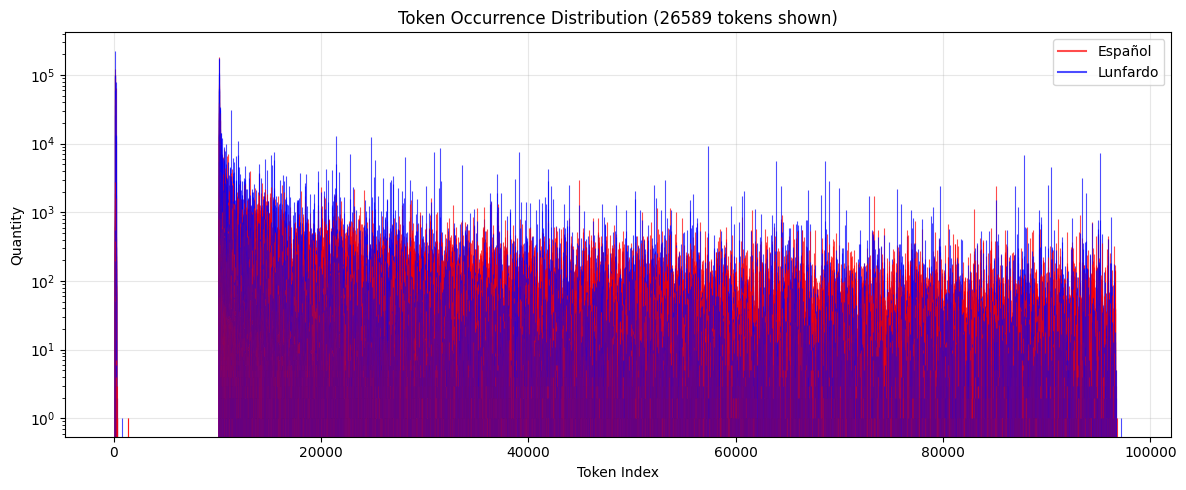

In [ ]:
from collections import Counter

def plot_token_occurrence(row1, row2, tokenizer, log=False, min_count=1, max_tokens=None):
    """
    Plot the occurrence of each token using vertical lines.
    
    Parameters:
    - row1, row2: pandas Series with text data
    - tokenizer: tokenizer object with vocab_size attribute and encode method
    - log: bool, whether to use log scale for y-axis
    - min_count: int, minimum count to display (filters rare tokens)
    - max_tokens: int, maximum number of tokens to display (most frequent)
    """
    
    # Initialize token counters
    token_counter_es = Counter()
    token_counter_lf = Counter()
    
    # Count tokens in row1 (Español)
    for txt in row1:
        if isinstance(txt, str):
            tokens = tokenizer.encode(txt, truncation=True)
            token_counter_es.update(tokens)
    
    # Count tokens in row2 (Lunfardo)
    for txt in row2:
        if isinstance(txt, str):
            tokens = tokenizer.encode(txt, truncation=True)
            token_counter_lf.update(tokens)
    
    # Get all unique tokens
    all_tokens = set(token_counter_es.keys()) | set(token_counter_lf.keys())
    
    # Filter tokens by minimum count
    if min_count > 1:
        all_tokens = {token for token in all_tokens 
                     if token_counter_es[token] + token_counter_lf[token] >= min_count}
    
    # Sort tokens and limit if specified
    sorted_tokens = sorted(all_tokens)
    if max_tokens:
        # Get top tokens by total frequency
        token_totals = [(token, token_counter_es[token] + token_counter_lf[token]) 
                       for token in sorted_tokens]
        token_totals.sort(key=lambda x: x[1], reverse=True)
        sorted_tokens = [token for token, _ in token_totals[:max_tokens]]
        sorted_tokens.sort()  # Sort by token index for x-axis
    
    # Prepare data for plotting
    x_positions = sorted_tokens
    y_es = [token_counter_es[token] for token in sorted_tokens]
    y_lf = [token_counter_lf[token] for token in sorted_tokens]
    
    # Create the plot
    plt.figure(figsize=(12, 5))
    
    # Plot vertical lines
    for i, token_id in enumerate(x_positions):
        if y_es[i] > 0:
            plt.vlines(token_id, 0, y_es[i], colors='red', alpha=0.7, linewidth=0.8)
        if y_lf[i] > 0:
            plt.vlines(token_id, 0, y_lf[i], colors='blue', alpha=0.7, linewidth=0.8)
    
    # Add custom legend
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], color='red', alpha=0.7, label='Español'),
                      Line2D([0], [0], color='blue', alpha=0.7, label='Lunfardo')]
    plt.legend(handles=legend_elements)
    
    # Set labels and scale
    plt.xlabel("Token Index")
    plt.ylabel("Quantity")
    if log:
        plt.yscale('log')
    
    # Set title
    total_tokens = len(sorted_tokens)
    plt.title(f"Token Occurrence Distribution ({total_tokens} tokens shown)")
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_token_occurrence(data['spanish'], data['lunfardo'], tokenizer, log=True)

In [31]:
import numpy as np
tokenizer.vocab_size

105879

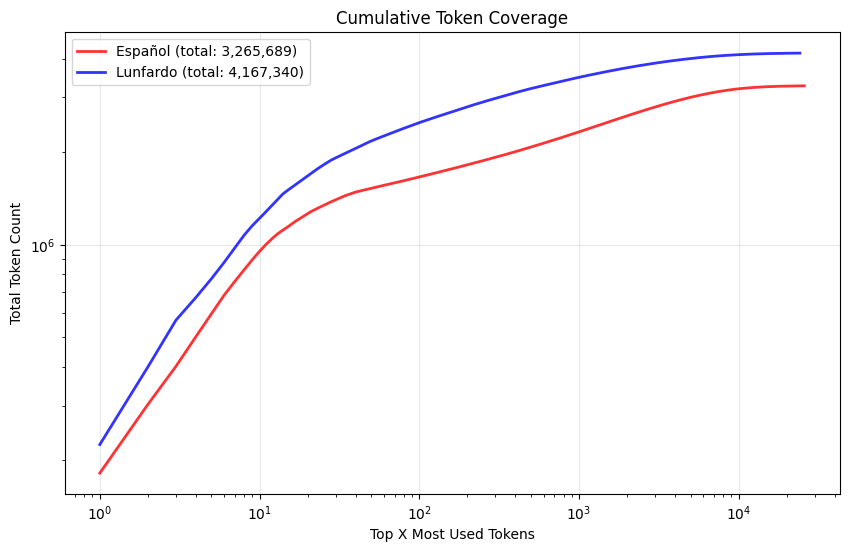


Token Coverage Statistics:
Threshold  Español         Lunfardo       
----------------------------------------
Top 10       29.1%          29.2%
Top 50       46.6%          51.9%
Top 100      50.7%          59.5%
Top 500      63.3%          76.8%
Top 1000     70.9%          83.5%
Top 5000     91.8%          96.1%
Top 10000    97.8%          98.9%
Top 500000  100.0%         100.0%
Top 105878  100.0%         100.0%

Vocabulary sizes:
Español: 25,748 unique tokens
Lunfardo: 24,150 unique tokens
Tokenizer vocab size: 105,879


In [33]:
def plot_cumulative_token_coverage(row1, row2, tokenizer, separate_plots=False):
    """
    Plot cumulative token coverage: how many total tokens you get when selecting 
    the top X most used tokens.
    
    Parameters:
    - row1, row2: pandas Series with text data
    - tokenizer: tokenizer object with vocab_size attribute and encode method
    - separate_plots: bool, whether to show separate plots for each dataset
    """
    
    # Initialize token counters
    token_counter_es = Counter()
    token_counter_lf = Counter()
    
    # Count tokens in row1 (Español)
    total_tokens_es = 0
    for txt in row1:
        if isinstance(txt, str):
            tokens = tokenizer.encode(txt)
            token_counter_es.update(tokens)
            total_tokens_es += len(tokens)
    
    # Count tokens in row2 (Lunfardo)
    total_tokens_lf = 0
    for txt in row2:
        if isinstance(txt, str):
            tokens = tokenizer.encode(txt)
            token_counter_lf.update(tokens)
            total_tokens_lf += len(tokens)
    
    # Sort tokens by frequency (descending)
    sorted_tokens_es = sorted(token_counter_es.items(), key=lambda x: x[1], reverse=True)
    sorted_tokens_lf = sorted(token_counter_lf.items(), key=lambda x: x[1], reverse=True)
    
    # Calculate cumulative token counts
    cumulative_es = []
    cumulative_lf = []
    running_sum_es = 0
    running_sum_lf = 0
    
    for token, count in sorted_tokens_es:
        running_sum_es += count
        cumulative_es.append(running_sum_es)
    
    for token, count in sorted_tokens_lf:
        running_sum_lf += count
        cumulative_lf.append(running_sum_lf)
    
    # Create x-axis (number of top tokens selected)
    x_es = np.arange(1, len(sorted_tokens_es) + 1)
    x_lf = np.arange(1, len(sorted_tokens_lf) + 1)
    
    if separate_plots:
        # Create separate subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Plot Español
        ax1.loglog(x_es, cumulative_es, color='red', linewidth=2, alpha=0.8)
        ax1.set_xlabel("Top X Most Used Tokens")
        ax1.set_ylabel("Total Token Count")
        ax1.set_title(f"Español - Total tokens: {total_tokens_es:,}")
        ax1.grid(True, alpha=0.3)
        
        # Plot Lunfardo
        ax2.loglog(x_lf, cumulative_lf, color='blue', linewidth=2, alpha=0.8)
        ax2.set_xlabel("Top X Most Used Tokens")
        ax2.set_ylabel("Total Token Count")
        ax2.set_title(f"Lunfardo - Total tokens: {total_tokens_lf:,}")
        ax2.grid(True, alpha=0.3)
        
        plt.suptitle("Cumulative Token Coverage")
        plt.tight_layout()
        
    else:
        # Single plot with both datasets
        plt.figure(figsize=(10, 6))
        plt.loglog(x_es, cumulative_es, color='red', linewidth=2, alpha=0.8, label=f'Español (total: {total_tokens_es:,})')
        plt.loglog(x_lf, cumulative_lf, color='blue', linewidth=2, alpha=0.8, label=f'Lunfardo (total: {total_tokens_lf:,})')
        
        plt.xlabel("Top X Most Used Tokens")
        plt.ylabel("Total Token Count")
        plt.title("Cumulative Token Coverage")
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    plt.show()
    
    # Print some statistics
    print("\nToken Coverage Statistics:")
    print("="*50)
    
    # Calculate coverage percentages for common thresholds
    thresholds = [10, 50, 100, 500, 1000, 5000, 10000, 500000, tokenizer.vocab_size-1]
    
    print(f"{'Threshold':<10} {'Español':<15} {'Lunfardo':<15}")
    print("-" * 40)
    
    for threshold in thresholds:
        if threshold <= len(cumulative_es):
            pct_es = (cumulative_es[threshold-1] / total_tokens_es) * 100
        else:
            pct_es = 100.0
            
        if threshold <= len(cumulative_lf):
            pct_lf = (cumulative_lf[threshold-1] / total_tokens_lf) * 100
        else:
            pct_lf = 100.0
            
        print(f"Top {threshold:<6} {pct_es:>6.1f}%        {pct_lf:>6.1f}%")
    
    print(f"\nVocabulary sizes:")
    print(f"Español: {len(sorted_tokens_es):,} unique tokens")
    print(f"Lunfardo: {len(sorted_tokens_lf):,} unique tokens")
    print(f"Tokenizer vocab size: {tokenizer.vocab_size:,}")

plot_cumulative_token_coverage(data['spanish'], data['lunfardo'], tokenizer)

Vamos a usar los top 10000 token para para la generacion

In [34]:
def get_top_tokens_with_specials(row1, row2, tokenizer, top_k=10000):
    token_counter = Counter()

    # Count tokens in both datasets
    for txt in list(row1):
        if isinstance(txt, str):
            tokens = tokenizer.encode(txt)
            token_counter.update(tokens)

    for txt in list(row2):
        if isinstance(txt, str):
            tokens = tokenizer.encode(txt)
            token_counter.update(tokens)

    # Get top_k tokens
    most_common_tokens = token_counter.most_common(top_k)
    sorted_selected = sorted([token_id for token_id, _ in most_common_tokens])

    return sorted_selected

top_tokens = get_top_tokens_with_specials(data['spanish'], data['lunfardo'], tokenizer)

In [35]:
top_tokens

[101,
 102,
 106,
 112,
 117,
 119,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 136,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 173,
 195,
 200,
 10102,
 10103,
 10104,
 10105,
 10106,
 10107,
 10108,
 10109,
 10110,
 10111,
 10112,
 10113,
 10114,
 10115,
 10116,
 10117,
 10118,
 10119,
 10120,
 10121,
 10123,
 10125,
 10126,
 10127,
 10128,
 10129,
 10130,
 10131,
 10132,
 10133,
 10134,
 10135,
 10136,
 10137,
 10139,
 10141,
 10142,
 10143,
 10144,
 10146,
 10147,
 10148,
 10149,
 10150,
 10152,
 10153,
 10154,
 10155,
 10156,
 10157,
 10158,
 10159,
 10160,
 10161,
 10162,
 10163,
 10165,
 10166,
 10167,
 10168,
 10169,
 10170,
 10172,
 10173,
 10174,
 10175,
 10177,
 10179,
 10180,
 10181,
 10182,
 10183,
 10186,
 10187,
 10188,
 10189,
 10190,
 10191,
 10192,
 10193,
 10194,
 10196,
 10197,
 10198,
 10199,
 10200,
 10202,
 10205,
 10206,
 10208